程式碼修改自:

https://www.tensorflow.org/tutorials/generative/style_transfer

本例中將使用VGG19的預訓練模型去實作固定維度(224x224)的Style Transfer(2015)風格轉換

# 使用VGG19 定義內容與風格表示

# 載入所需使用*模組* 與 *相關配置*

In [57]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

import PIL.Image

import tensorflow as tf

#量測程式執行時間用
import time

# 載入 tensorflow hub操作套件
import tensorflow_hub as hub

import IPython.display as display

## 下載風格與待轉換影像

In [58]:
content_path = tf.keras.utils.get_file('content_autumn.jpg', 'https://upload.wikimedia.org/wikipedia/commons/1/12/Autumn_scene_at_Woodleigh_%286_of_7%29.jpg')
style_path = tf.keras.utils.get_file('style_winter.jpg','https://upload.wikimedia.org/wikipedia/commons/3/32/20190111_Sninsky_kamen.jpg')

# 視覺化顯示相關函式

## 依比例縮放影像, 最大維度為 *512*

(實際上VGG19僅能輸入224x224維度影像，此處只是先做等比例縮放)

In [59]:
def load_img(path_to_img):
    max_dim = 512
    
    # 讀取影像
    img = tf.io.read_file(path_to_img) # 讀取影像至tf上
    img = tf.image.decode_image(img, channels=3) # 解碼影像(將類似0x7b轉換為對應影像數值)
    
    img = tf.image.convert_image_dtype(img, tf.float32) # 轉換數值範圍至[0,1)

    # 計算縮放比例
    shape = tf.cast(tf.shape(img)[:-1], tf.float32)    #-1是用來不考慮尾端的chaanel，再進行影像尺寸計算
    long_dim = max(shape)       #算出長軸的維度
    scale = max_dim / long_dim  #算出縮放的比例
    
    # 計算依比例縮放後維度
    new_shape = tf.cast(shape * scale, tf.int32)   
    
    # 影像縮放
    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]    #用tf.newaxis將batch的維度加上去
    return img


#重點一: Tensor影像數值為0~1之間的浮點數
#重點二: 最終維度為batch, image_dim, channel

In [60]:
#將tf網路變數(tf.Tensor)轉換成PIL格式影像(可想像成帶有檔頭的numpy array)
#這樣後面可以直接用PIL的存檔功能

def tensor_to_image(tensor):
    #將tensor格式(0~1)轉為0~255的影像
    tensor = tensor*255   #
    tensor = np.array(tensor, dtype=np.uint8)   #轉換成int的array    
    if np.ndim(tensor)>3:
        assert tensor.shape[0] == 1         #削掉batch
        tensor = tensor[0]        
    return PIL.Image.fromarray(tensor)      #回傳PIL的格式

In [61]:
#將顯示影像包成一個函數
#直接用imshow就可以show出影像
def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)    #去掉batch所在的維度

    plt.imshow(image)
    if title:
        plt.title(title)       #顯示title在圖片上方
        

## 顯示目前的內容與風格影像

In [62]:
content_image = load_img(content_path)
style_image = load_img(style_path)

# plt.subplot(1, 2, 1)
# imshow(content_image, 'Content Image')

# plt.subplot(1, 2, 2)
# imshow(style_image, 'Style Image')

# 使用預訓練網路(VGG19)建立模型

使用Keras的 functional API去指定模型之輸入/輸出

`model = Model(inputs, outputs)`

In [63]:
#匯入vgg模型，並輸出對應layer_names的內容

def vgg_layers(layer_names):
    # Load our model. Load pretrained VGG, trained on imagenet data
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
  
    outputs = [vgg.get_layer(name).output for name in layer_names]

    model = tf.keras.Model([vgg.input], outputs)
    return model

In [64]:
show_layers = ['block1_conv1']

#選定想看的layer名稱後，丟進vgg_layers裡
show_extractor = vgg_layers(show_layers)

#之前的tensor會將影像縮放至0~1之間，因此在餵入時要*255
inputs = style_image*255
preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)

show_outputs = show_extractor(preprocessed_input)

print(show_outputs.numpy().shape)

#去掉最前面的batch
show_image = show_outputs.numpy().squeeze()
print(show_image.shape)


(1, 256, 512, 64)
(256, 512, 64)


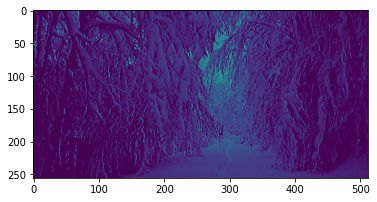

In [65]:
plt.imshow(show_image[:,:,2])

練習:
1. 根據前面輸出layer名稱, 修改`show_layers` 值內容, 觀察輸出結果
2. 將`style_image`修改為`content_image`, 觀察提取**內容**與**風格**差異

## 設定神經網路內容層與風格層

設定想使用的**內容**與**風格**層

In [66]:
# 內容層
content_layers = ['block5_conv2']

# 風格層
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

顯示內容層與風格層統計數值

In [67]:
# style_extractor = vgg_layers(style_layers)

# inputs = style_image*255
# preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
# style_outputs = style_extractor(preprocessed_input)

# #Look at the statistics of each layer's output
# for name, output in zip(style_layers, style_outputs):
#     print(name)
#     print("  shape: ", output.numpy().shape)
#     print("  min: ", output.numpy().min())
#     print("  max: ", output.numpy().max())
#     print("  mean: ", output.numpy().mean())
#     print()

## 風格計算

影像可以通過不同feature maps (特徵圖)上的平均值、相關性等統計資訊來描述。計算不同channel的內積，可以算出包含不同channel相關性的Gram 矩陣，具體計算方法如下所示：

$$G^l_{cd} = \frac{\sum_{ij} F^l_{ijc}(x)F^l_{ijd}(x)}{IJ}$$


可以使用 `tf.linalg.einsum` 函數來實現，該函數簡單的解說可參考以下連結：

https://stackoverflow.com/questions/65030112/converting-einsum-notation-to-for-loops

In [68]:
#回傳input的gram_matrix
#例如輸入為(256, 512, 64)，由64個channel的影像所組成
#將會計算這64個channel的內容(將256 x 512攤平成一維)彼此跟對方內積  
#產生64 x 64的矩陣

def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)    
    return result/(num_locations)           #回傳gram_matrix(除以總數)

## 提取風格與內容

In [69]:
class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):

#讓這個類別StyleContentModel所宣告的物件能使用tf.keras.models.Model其他的功能與函數
        super(StyleContentModel, self).__init__()
    
#利用vgg_layer的函數，將style和content都丟進去，宣告出vgg的模型
        self.vgg =  vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False      #凍結vgg的權重，避免他被更新


    def call(self, inputs):

#呼叫時，將input丟進來做影像前處理，產出跑完vgg模型的output
        inputs = inputs*255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)

#將output分成style和content
        style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                          outputs[self.num_style_layers:])

#計算gram_matrix當作style_outputs, content_outputs維持不變
        style_outputs = [gram_matrix(style_output)
                         for style_output in style_outputs]

#輸出為字典格式 content和 style，方便後面使用
#裡面還包含了名稱(content_name,style_name)和實際輸出內容
        content_dict = {content_name:value 
                        for content_name, value 
                        in zip(self.content_layers, content_outputs)}

        style_dict = {style_name:value
                      for style_name, value
                      in zip(self.style_layers, style_outputs)}
        
        return {'content':content_dict, 'style':style_dict}

將影像餵入此模型，可以返回 style_layers 的 gram 矩陣（風格）和 content_layers 的內容

In [70]:
#宣告一個上述類別的物件
extractor = StyleContentModel(style_layers, content_layers)

#將影像丟進去物件裡，它會回傳gram矩陣和content_layers內容
results = extractor(tf.constant(content_image))

# print('Styles:')
# for name, output in sorted(results['style'].items()):
#     print("  ", name)
#     print("    shape: ", output.numpy().shape)
#     print("    min: ", output.numpy().min())
#     print("    max: ", output.numpy().max())
#     print("    mean: ", output.numpy().mean())
#     print()

# print("Contents:")
# for name, output in sorted(results['content'].items()):
#     print("  ", name)
#     print("    shape: ", output.numpy().shape)
#     print("    min: ", output.numpy().min())
#     print("    max: ", output.numpy().max())
#     print("    mean: ", output.numpy().mean())


# 梯度下降

使用此風格和內容提取器，現在可以實現風格轉換。通過計算每個圖像的輸出和目標的均方誤差來做到這一點，然後取這些損失值的加權和。

設置風格和內容的目標值：

In [71]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

限制Pixel value值範圍為 0~1之間

In [72]:
def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

建立優化器(Optimizer), Paper使用 LBFGS, 此處使用Adam一樣可正常運作

In [73]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

(使用tf.Varable初始化)設定影像起始猜值

In [74]:
image = tf.Variable(content_image)

設定風格與內容的加權值

In [75]:
style_weight=1e-2
content_weight=1e4

#total_variation_weight=30

In [76]:
#計算loss的函數
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']

#style的loss
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    
    style_loss *= style_weight / num_style_layers

#content的loss
    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    
    loss = style_loss + content_loss
    return loss

使用tf.GradientTape更新影像

In [77]:

@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:        
        outputs = extractor(image)   #丟image影像

        loss = style_content_loss(outputs)   #算loss
#        loss += total_variation_weight*tf.image.total_variation(image)

    grad = tape.gradient(loss, image)    #算梯度    

    opt.apply_gradients([(grad, image)])   #將梯度更新在影像本身
    
    image.assign(clip_0_1(image))    #避免影像超過數值範圍

執行一個step測試一下

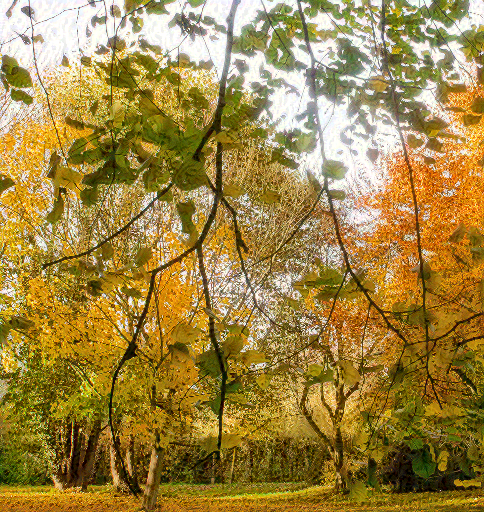

In [78]:
train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image)

看起來可以正常運作, 多跑幾次step看看

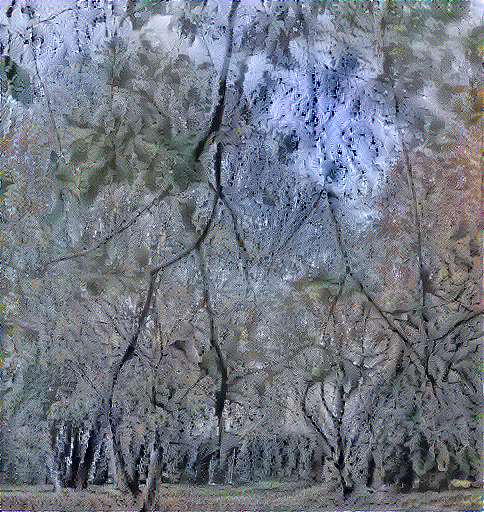

Train step: 1000
Total time: 22.4


In [79]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image)
        print(".", end='')
    display.clear_output(wait=True)
    display.display(tensor_to_image(image))
    print("Train step: {}".format(step))
    
end = time.time()
print("Total time: {:.1f}".format(end-start))

In [80]:
file_name = 'stylized-image.png'
tensor_to_image(image).save(file_name)

練習:

*可嘗試使用不同style_weight, content_weight

*內容與風格層使用不同Layer設定看會有什麼變化


# Total variation loss (進階)

前述實現只是一個基礎版本，它的一個缺點是它會產生大量的高頻誤差。

可以直接通過正則化圖像的高頻部分來減少這些高頻誤差。在風格轉換中，通常被稱為Total variation loss：

In [26]:
def high_pass_x_y(image):
    x_var = image[:,:,1:,:] - image[:,:,:-1,:]
    y_var = image[:,1:,:,:] - image[:,:-1,:,:]

    return x_var, y_var

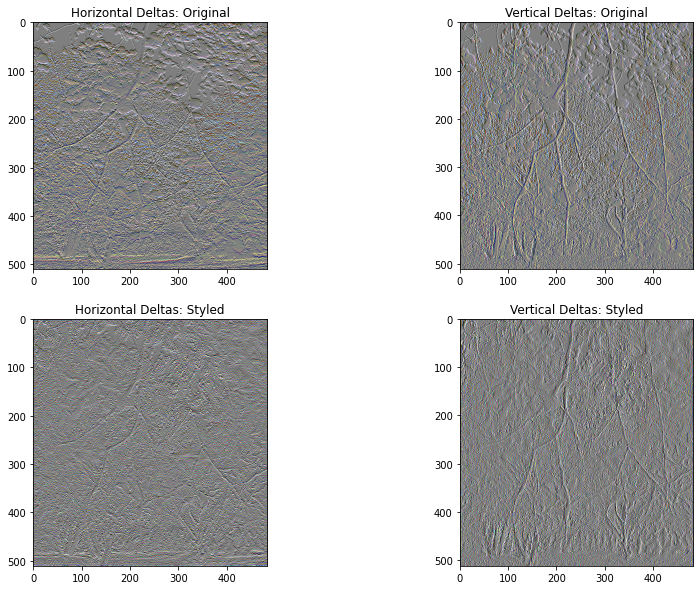

In [27]:
x_deltas, y_deltas = high_pass_x_y(content_image)

plt.figure(figsize=(14,10))
plt.subplot(2,2,1)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Original")

plt.subplot(2,2,2)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Original")

x_deltas, y_deltas = high_pass_x_y(image)

plt.subplot(2,2,3)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Styled")

plt.subplot(2,2,4)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Styled")

本質上高頻部分是一個邊緣檢測器。我們可以從 Sobel 邊緣檢測器獲得類似的輸出

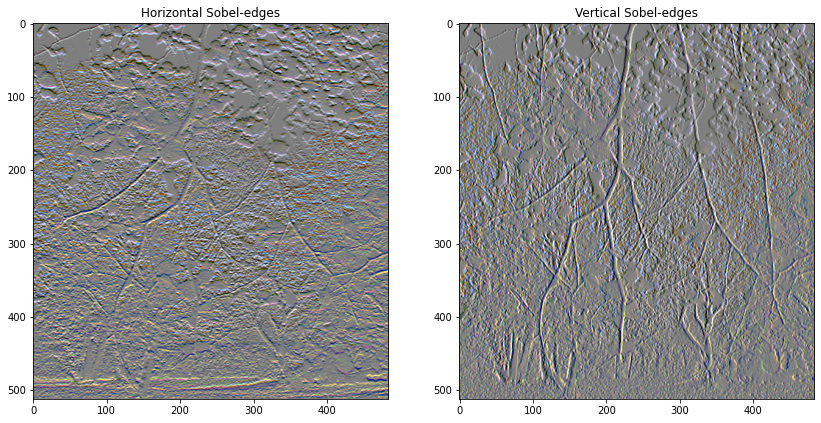

In [28]:
plt.figure(figsize=(14,10))

sobel = tf.image.sobel_edges(content_image)
plt.subplot(1,2,1)
imshow(clip_0_1(sobel[...,0]/4+0.5), "Horizontal Sobel-edges")
plt.subplot(1,2,2)
imshow(clip_0_1(sobel[...,1]/4+0.5), "Vertical Sobel-edges")

The regularization loss associated with this is the sum of the squares of the values:

In [29]:
def total_variation_loss(image):
    x_deltas, y_deltas = high_pass_x_y(image)
    return tf.reduce_sum(tf.abs(x_deltas)) + tf.reduce_sum(tf.abs(y_deltas))

In [30]:
total_variation_loss(image).numpy()

199603.56

以上說明了Total variation loss的用途。但是無需自己實現，因為 TensorFlow 包含了一個標準實現：

In [31]:
tf.image.total_variation(image).numpy()

array([199603.56], dtype=float32)